In [1]:
import pickle
import numpy as np
from sklearn.neighbors import NearestNeighbors

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

## Read in Embeddings and Word Dictionary

In [2]:
mus = np.load('final-pass/mu.npy')
logsigmas = np.load('final-pass/sigma.npy')
word_dictionary = pickle.load(open('final-pass/word2id.pkl', 'rb'), encoding='latin1')

# Decode from bytes
word_dictionary = {key: value for key, value in word_dictionary.items()}
reversed_word_dictionary = {value: key for key, value in word_dictionary.items()}

In [3]:
print('Shape of mus: {}'.format(mus.shape))
print('Shape of logsigmas: {}'.format(logsigmas.shape))
print('Vocabulary size: {}'.format(len(word_dictionary)))

Shape of mus: (716591, 4, 50)
Shape of logsigmas: (716591, 4, 1)
Vocabulary size: 716591


In [4]:
# Sanity check
assert not (np.isnan(mus).any() or np.isnan(logsigmas).any())

## Check similarity of words

In [5]:
def el_similarity(mu1, mu2, sigma1, sigma2):
    foo = np.log((sigma1 + sigma2) ** 50)
    bar = 50 * np.log(2*np.pi)
    baz = np.sum((mu1 - mu2) ** 2 / (sigma1 + sigma2))
    return -0.5 * (foo + bar + baz)

In [6]:
word = 'apple'
idx = word_dictionary[word]

In [7]:
mus_ = mus[idx]
sigmas_ = np.exp(logsigmas[idx]).flatten()
[(i, j, el_similarity(mus_[i], mus_[j], sigmas_[i], sigmas_[j])) for j in range(4) for i in range(j)]

[(0, 1, 8.100415932028433),
 (0, 2, 6.412691990373865),
 (1, 2, 11.522438664966643),
 (0, 3, 5.654944818254499),
 (1, 3, 3.4584979430150398),
 (2, 3, 3.556470331985331)]

In [10]:
N = 1000
mu_rand1 = np.random.uniform(-1, 1, N)
mu_rand2 = np.random.uniform(-1, 1, N)
sigma_rand1 = 0.05
sigma_rand2 = 0.05

x = [el_similarity(mu_rand1[i], mu_rand2[j], sigma_rand1, sigma_rand2) for i in range(N) for j in range(N)]

/Users/george/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Distribution of Similarities')

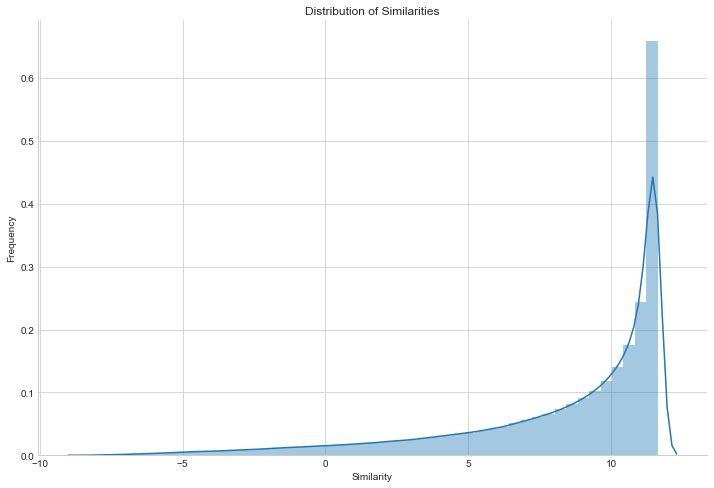

In [11]:
plt.subplots(figsize=[12, 8])
sns.distplot(x)
sns.despine()
plt.xlabel('Similarity')
plt.ylabel('Frequency')
plt.title('Distribution of Similarities')

## kNN Analysis

In [8]:
knn = NearestNeighbors(n_neighbors=10).fit(mus.reshape(-1, 50, order='F'))  # It's important that order='F'!

'''
knn0 = NearestNeighbors(n_neighbors=10).fit(mus[:, 0, :])
knn1 = NearestNeighbors(n_neighbors=10).fit(mus[:, 1, :])
knn2 = NearestNeighbors(n_neighbors=10).fit(mus[:, 2, :])
knn3 = NearestNeighbors(n_neighbors=10).fit(mus[:, 3, :])
knn = [knn0, knn1, knn2, knn3]
''';

In [19]:
words = ['rock', 'bank', 'apple', 'star', 'cell', 'left',
         'tank', 'board', 'record', 'lie', 'right', 'chair', 'bar', 'lead']

for word in words:
    idx = word_dictionary[word]
    embedding = mus[idx]
    for i in range(4):
        distances, indices = knn.kneighbors(embedding[i].reshape(1, -1))
        lst = [reversed_word_dictionary[j % len(reversed_word_dictionary)] for j in indices.flatten()]
        print(lst[0] + '\t' + ' '.join(lst[1:]))

rock	rocks limestone slope range. rock. caldera mountain petrified summit
rock	rocks hard rocky well california up enon known smooth
rock	rock bands reggae rock. punk albums. rb pop selftitled
rock	rock rock. reggae bands punk albums. thrash bands soul
bank	hill edge point stretch northwest east just across side
bank	bank bank. branches central its renaming capital. it renamed
bank	securities banks banking assets. investment shareholders asset holding investor
bank	bank bank. banks banking invested branches sterling branch banco
apple	portable macintosh standalone iwork machine. developer run project developers
apple	apple apples iphone xen shipped microsoft package treo os2
apple	apple apples honey peanut apples vanilla onions flavors chips
apple	wasnt recalls rockpile decided hecky ebel thornley 0for4 winds
star	enckelman blue time a took one this three femi
star	star stars. nebula brightest star. galaxy centauri moons stellar
star	star star. galaxy nebula stars stars. brightest supe

## Hard Decision

In [20]:
for word in words:
    idx = word_dictionary[word]
    embedding = mus[idx]
    mus_ = mus[idx]
    sigmas_ = np.exp(logsigmas[idx]).flatten()
    similarities = [(i, j, el_similarity(mus_[i], mus_[j], sigmas_[i], sigmas_[j]))
                    for j in range(4) for i in range(j)]
    
    asdf = np.array(similarities)

    for inds, sim in zip(asdf[:, :2], asdf[:, 2]):
        if sim > 9:
            print(inds)
    
    for i in range(4):
        distances, indices = knn.kneighbors(embedding[i].reshape(1, -1))
        lst = [reversed_word_dictionary[j % len(reversed_word_dictionary)] for j in indices.flatten()]
        print(lst[0] + '\t' + ' '.join(lst[1:]))
        
    print(80*'-')

[2. 3.]
rock	rocks limestone slope range. rock. caldera mountain petrified summit
rock	rocks hard rocky well california up enon known smooth
rock	rock bands reggae rock. punk albums. rb pop selftitled
rock	rock rock. reggae bands punk albums. thrash bands soul
--------------------------------------------------------------------------------
[1. 3.]
bank	hill edge point stretch northwest east just across side
bank	bank bank. branches central its renaming capital. it renamed
bank	securities banks banking assets. investment shareholders asset holding investor
bank	bank bank. banks banking invested branches sterling branch banco
--------------------------------------------------------------------------------
[1. 2.]
apple	portable macintosh standalone iwork machine. developer run project developers
apple	apple apples iphone xen shipped microsoft package treo os2
apple	apple apples honey peanut apples vanilla onions flavors chips
apple	wasnt recalls rockpile decided hecky ebel thornley 0for4